## QCNN implementation

In [1]:
import matplotlib.pyplot as plt
from source.qcnn import *

### Calling model and training

In [2]:
test_class = QCNN()
train_load, train_lab, test_load, test_lab = test_class.generate_data()
model, preds = train(train_load,train_lab)

### Testing the trained model

In [3]:
preds, accuracy = test(model, test_load, test_lab)
print(accuracy)

0.9


### Plot results and visualize phase diagram

Text(0.5, 1.0, 'QCNN classification (1 = trivial, 0 = topological)')

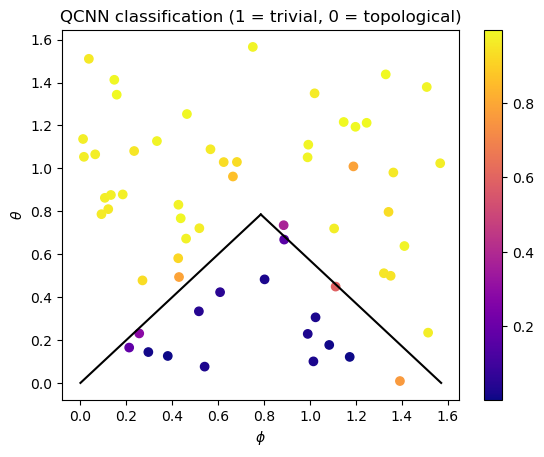

In [10]:
f, ax = plt.subplots()
phis = []
thetas = []
pred_s = []
for i, angles in enumerate(test_load):
    pred = preds[i].detach().numpy()
    theta = angles[0].detach().numpy()
    phi = angles[1].detach().numpy()
    phis.append(phi)
    thetas.append(theta)
    pred_s.append(pred)

points = ax.scatter(phis, thetas, c=pred_s,cmap='plasma')
f.colorbar(points)
ax.plot(np.linspace(0, np.pi/4, 50), np.linspace(0, np.pi/4, 50), c = 'k')
ax.plot(np.linspace(np.pi/4, np.pi/2, 50), np.ones(50)*np.pi/2-np.linspace(np.pi/4, np.pi/2, 50), c = 'k')
ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$\theta$')
ax.set_title('QCNN classification (1 = trivial, 0 = topological)')